# Sarcasm detection

Dataset original source:

- [Kaggle](https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection)

Build a predictive model

- Compare: NB, KNN, SVM

Theorical sources

- [NB](https://en.wikipedia.org/wiki/Naive_Bayes_classifier)
- [KNN](https://www.codecademy.com/learn/introduction-to-supervised-learning-skill-path/modules/k-nearest-neighbors-skill-path/cheatsheet)
- [SVM](https://es.wikipedia.org/wiki/M%C3%A1quinas_de_vectores_de_soporte)

Sklearn algorithm references

- [Column Transformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html)
- [One Hot Encoder](https://datagy.io/sklearn-one-hot-encode/)
- [Text feature extraction](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
- [NB](https://scikit-learn.org/stable/modules/naive_bayes.html)
- [KNN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
- [SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

## Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from wordcloud import WordCloud

import nltk
#nltk.download('stopwords')
#nltk.download('wordnet')

import warnings
warnings.filterwarnings('ignore')

## The data

In [2]:
dataset_name = 'Sarcasm_Headlines_Dataset.json'
df = pd.read_json(dataset_name, lines=True)

In [3]:
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


## Exploratory data analysis

In [4]:
df.shape

(26709, 3)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  26709 non-null  object
 1   headline      26709 non-null  object
 2   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 626.1+ KB


In [6]:
df.isna().sum()

article_link    0
headline        0
is_sarcastic    0
dtype: int64

### Get ride of duplicated headlines

In [7]:
df['headline'].duplicated().sum()

107

In [8]:
df[df['headline'].duplicated()].index

Int64Index([ 1091,  2265,  2975,  3802,  4605,  5154,  5789,  6383,  6642,
             6685,
            ...
            25115, 25118, 25855, 25995, 26026, 26121, 26156, 26353, 26500,
            26615],
           dtype='int64', length=107)

In [9]:
df = df.drop(df[df['headline'].duplicated()].index, axis=0)

In [10]:
df['headline'].duplicated().sum()

0

### The transmitter

In [11]:
extract_transmitter = lambda url : url.split('.')[1]
df['transmitter'] = df['article_link'].apply(extract_transmitter)
df.head()

,article_link,headline,is_sarcastic,transmitter
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0,huffingtonpost
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0,huffingtonpost
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1,theonion
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1,theonion
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0,huffingtonpost


### Sarcastic distribution

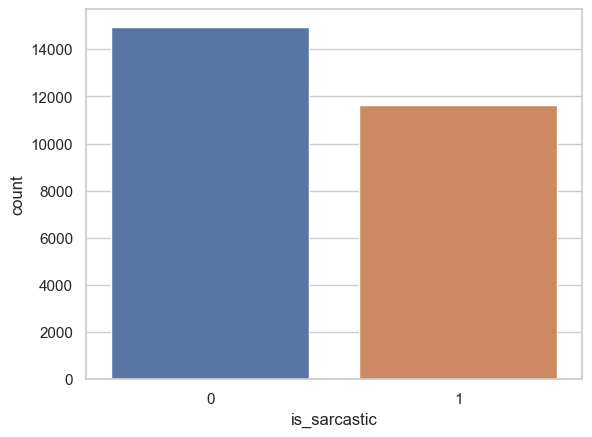

In [12]:
# here I notice that the dependent variable is unbalanced.
# there are arround 4K more samples of non sarcastic headlines
sns.set_theme(style='whitegrid')
ax = sns.countplot(x='is_sarcastic', data=df)

### Transmitter distribution

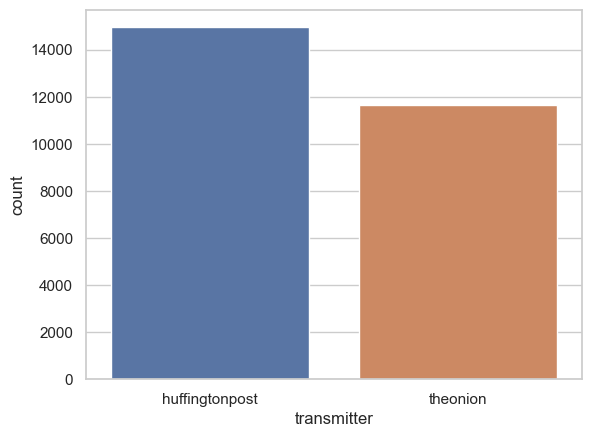

In [13]:
# here I notice that the dependent variable is unbalanced. Not that much yet unbalanced
sns.set_theme(style='whitegrid')
ax = sns.countplot(x='transmitter', data=df)

### Linear correlation between features

I noticed that the countplots from **trasnsmitter distribution** and **sarcastic distribution** are quite similar. I want to know if they are that much related

In [14]:
from pandas import factorize

columns = ['transmitter', 'is_sarcastic']
X = df[columns]
X.loc[:, 'transmitter'] = factorize(X['transmitter'])[0]

It's important to note that a matrix of all ones is a very unlikely scenario in real-world data, as it would indicate that all of the variables are perfectly related and there is no variability or uniqueness in the data. However, with this information I deduce that **theonion** source always throw sarcastic headlines meanwhile **huffingtonpost** always gives non-sarcastic headlines.

In [15]:
# calculate the correlation matrix
corr = X.corr()
corr

,transmitter,is_sarcastic
transmitter,1.0,1.0
is_sarcastic,1.0,1.0


## Feature extraction

In this section I present the way I map from raw text to vectoriezed samples in order to inject the vectorized samples into M.L models

### Denoise headlines

In [16]:
def denoise_text(text: str):
    
    from nltk.tokenize import RegexpTokenizer
    from nltk.corpus import stopwords
    from nltk.stem import PorterStemmer, WordNetLemmatizer
    
    def concat(tokens):
        return ' '.join(tokens)

    # lower case
    text = text.lower()
    
    # remove punctuation
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    
    # remove numbers
    tokens = [token for token in tokens if not token.isnumeric()]
    
    # remove stop words
    stop_words = stopwords.words('english')
    tokens = [token for token in tokens if token not in stop_words]
    
    # stem words
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]

    # lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return concat(tokens)

In [ ]:
df['clean_headline'] = df['headline'].apply(denoise_text)

In [ ]:
df[['headline', 'clean_headline']].head(10)

In [ ]:
# more frequent words used in not sarcastic headlines
ns_words = ' '.join(df[df['is_sarcastic'] == 0]['clean_headline'])
wc = WordCloud(max_words = 15, collocations = False, background_color = 'white').generate(ns_words)
plt.imshow(wc , interpolation = 'bilinear')
plt.axis("off")
plt.show()

In [ ]:
# more frequent words used in sarcastic headlines
ns_words = ' '.join(df[df['is_sarcastic'] == 1]['clean_headline'])
wc = WordCloud(max_words = 15, collocations = False, background_color = 'white').generate(ns_words)
plt.imshow(wc , interpolation = 'bilinear')
plt.axis("off")
plt.show()

### Vectorize words

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html